<a href="https://colab.research.google.com/github/VillePajala/Vehicle-classifier/blob/main/vehicle_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', 'xxx')

In [ ]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [ ]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [ ]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [ ]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

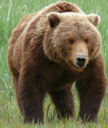

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
fns = get_image_files(path)
fns

(#422) [Path('bears/grizzly/f5e4fc7e-23be-439d-913e-f1de666f7c8b.jpg'),Path('bears/grizzly/d67e8278-51c6-4501-b3d9-95bb0e0a4413.jpg'),Path('bears/grizzly/59a8f8ad-2108-4f72-a2cb-1c89c34d7749.jpg'),Path('bears/grizzly/d2ac0bac-f7ce-4869-b716-49f694e7c76f.jpg'),Path('bears/grizzly/c6edc449-08d2-4c77-863e-aac47e369b87.jpg'),Path('bears/grizzly/f3eea2f4-8880-4072-a05e-d67833d18a2b.jpg'),Path('bears/grizzly/4235fc5d-ff2b-470c-9082-2daef044296c.jpg'),Path('bears/grizzly/ae626164-7e4f-4415-8c05-c0fe1a038514.jpg'),Path('bears/grizzly/2ac46d98-6d23-4f28-98ca-76798abf624b.jpg'),Path('bears/grizzly/07416fb3-2a6a-4d47-87bf-7fad308d01c6.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#5) [Path('bears/grizzly/4a965b3b-3be5-4bdd-9b92-1f875d42da41.JPG'),Path('bears/grizzly/5627c541-cfdf-4aa0-b399-bb6ea46e5d3c.jpg'),Path('bears/black/ab2159b2-7af0-4a09-b9ae-44d914215df2.jpg'),Path('bears/teddy/b69a27a2-a4f8-4d15-8bd6-f91cdeba5741.png'),Path('bears/teddy/df6a4f4b-807e-4283-bbd8-00e55778be36.jpg')]

In [ ]:
failed.map(Path.unlink);

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = bears.dataloaders(path)

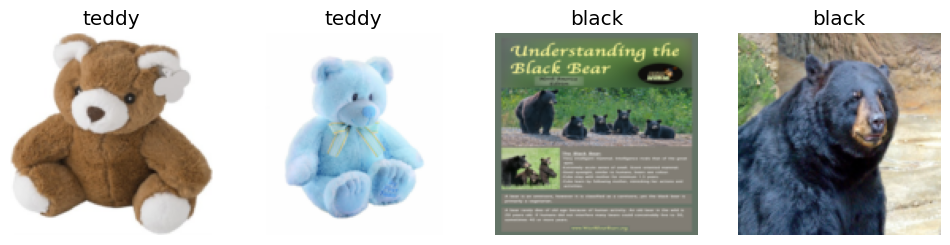

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

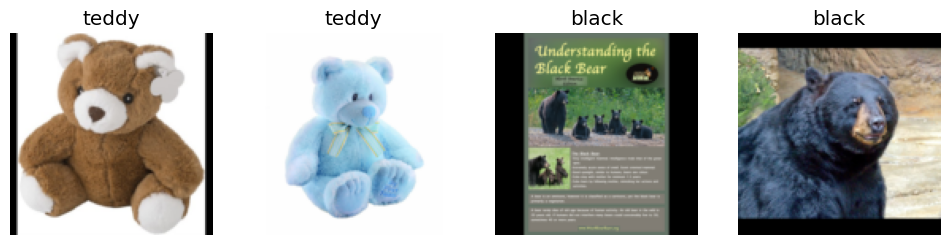

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

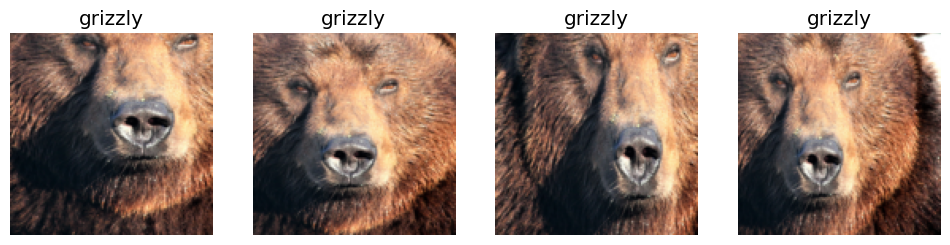

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

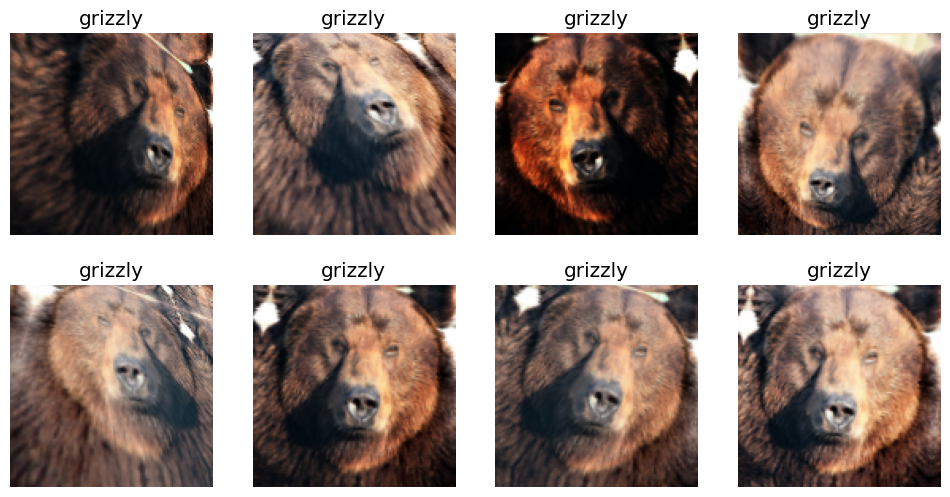

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


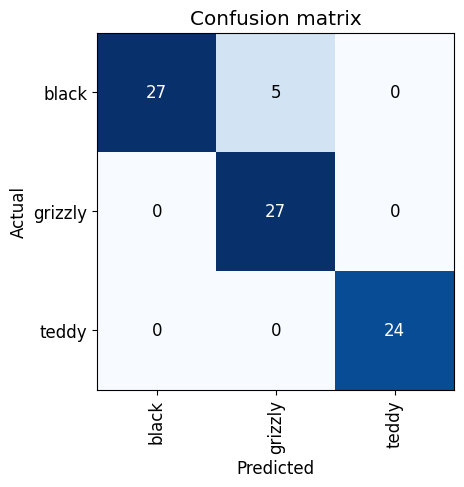

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

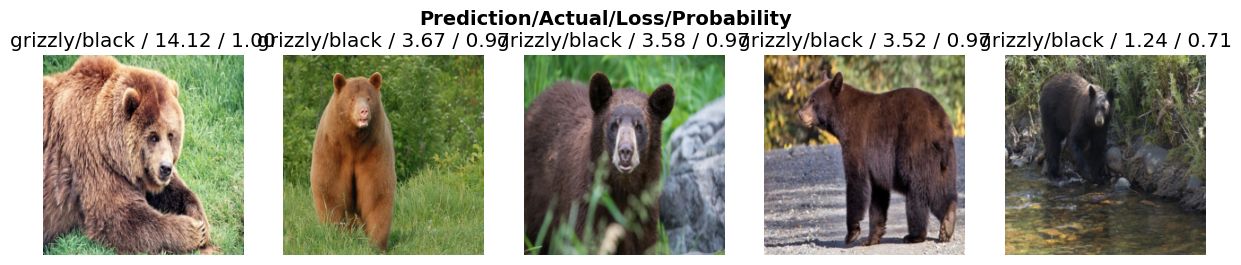

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

<img alt="Cleaner widget" width="700" src="https://github.com/fastai/fastbook/blob/master/images/att_00007.png?raw=1">

In [ ]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Error: Destination path 'bears/black/0fda4285-0beb-44f5-9983-71b81990a357.jpg' already exists

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([2.0346e-06, 1.0000e+00, 9.5914e-08]))

In [ ]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [ ]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

<img alt="Output widget representing the image" width="117" src="https://github.com/fastai/fastbook/blob/master/images/att_00009.png?raw=1">

In [ ]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [ ]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
#hide_output
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

IndexError: list index out of range

<img alt="The whole widget" width="233" src="https://github.com/fastai/fastbook/blob/master/images/att_00011.png?raw=1">

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila